In [32]:
import numpy as np

class LogisticRegression:
    def __init__(self, learning_rate=0.001, n_iters=1000, gd_algorithm='gradient_descent', batch_size=32, momentum=0.9):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None
        self.losses = []

        self.gd_algorithm = gd_algorithm

        self.batch_size = batch_size

        self.momentum = momentum
        self.velocity_w = 1
        self.velocity_b = 1

         
    #Sigmoid method
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def compute_loss(self, y_true, y_pred):
        # binary cross entropy
        epsilon = 1e-9
        y1 = y_true * np.log(y_pred + epsilon)
        y2 = (1-y_true) * np.log(1 - y_pred + epsilon)
        return -np.mean(y1 + y2)

    def feed_forward(self,X):
        z = np.dot(X, self.weights) + self.bias
        A = self._sigmoid(z)
        return A

    def gradient_descent(self, X, y):
        n_samples, n_features = X.shape
        A = self.feed_forward(X)
        dz = A - y # derivative of sigmoid and bce X.T*(A-y)
        dw = (1 / n_samples) * np.dot(X.T, dz)
        db = (1 / n_samples) * np.sum(dz)

        self.weights -= self.lr * dw
        self.bias -= self.lr * db

    def momentum_gradient_descent(self, X, y):
        n_samples, n_features = X.shape
        self.velocity_w = np.zeros(n_features)  # Initialize velocity for weights

        A = self.feed_forward(X)
        dz = A - y  # derivative of sigmoid and bce X.T*(A-y)
        dw = (1 / n_samples) * np.dot(X.T, dz)
        db = (1 / n_samples) * np.sum(dz)

        # Update velocity and weights with momentum
        self.velocity_w = self.momentum * self.velocity_w - self.lr * dw
        self.velocity_b = self.momentum * self.velocity_b - self.lr * db

        self.weights += self.velocity_w
        self.bias += self.velocity_b

    def stochastic_gradient_descent(self, X, y):
        n_samples, n_features = X.shape
        for i in range(n_samples):
            xi = X[i].reshape(1, -1)  # Reshape to keep it 2D
            yi = y[i].reshape(1, -1)  # Reshape to keep it 2D

            # Forward pass
            A = self.feed_forward(xi)
            dz = A - yi
            dw = np.dot(xi.T, dz).flatten()
            db = np.sum(dz)

            # Update weights and bias
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def mini_batch_stochastic_gradient_descent(self, X, y):
        n_samples, n_features = X.shape
        for _ in range(self.n_iters):
            # Shuffle the data
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for start_idx in range(0, n_samples, self.batch_size):
                end_idx = min(start_idx + self.batch_size, n_samples)
                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]

                # Forward pass
                A = self.feed_forward(X_batch)
                dz = A - y_batch
                dw = (1 / X_batch.shape[0]) * np.dot(X_batch.T, dz)
                db = (1 / X_batch.shape[0]) * np.sum(dz)

                # Update weights and bias
                self.weights -= self.lr * dw
                self.bias -= self.lr * db

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # init parameters
        self.weights = np.zeros(n_features)
        self.bias = 0

        # gradient descent
        for _ in range(self.n_iters):
            A = self.feed_forward(X)
            self.losses.append(self.compute_loss(y,A))

            if self.gd_algorithm == 'gradient_descent':
                self.gradient_descent(X, y)
            elif self.gd_algorithm == 'momentum_gradient_descent':
                self.momentum_gradient_descent(X, y)
            elif self.gd_algorithm == 'stochastic_gradient_descent':
                self.stochastic_gradient_descent(X, y)
            elif self.gd_algorithm == 'mini_batch_stochastic_gradient_descent':
                self.mini_batch_stochastic_gradient_descent(X, y)

    def predict(self, X):
        threshold = .5
        y_hat = np.dot(X, self.weights) + self.bias
        y_predicted = self._sigmoid(y_hat)
        y_predicted_cls = [1 if i > threshold else 0 for i in y_predicted]
        
        return np.array(y_predicted_cls)

In [33]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

dataset = datasets.load_breast_cancer()
X, y = dataset.data, dataset.target

X, y = dataset.data, dataset.target 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

regressor = LogisticRegression(learning_rate=0.0001, n_iters=1000)
regressor.fit(X_train, y_train)
predictions = regressor.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)

print("Test accuracy: {0:.3f}".format(accuracy))

Test accuracy: 0.500


/var/folders/2m/zt75k_js249d_qcmywz2vb0r0000gp/T/ipykernel_93716/4198201370.py:22: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


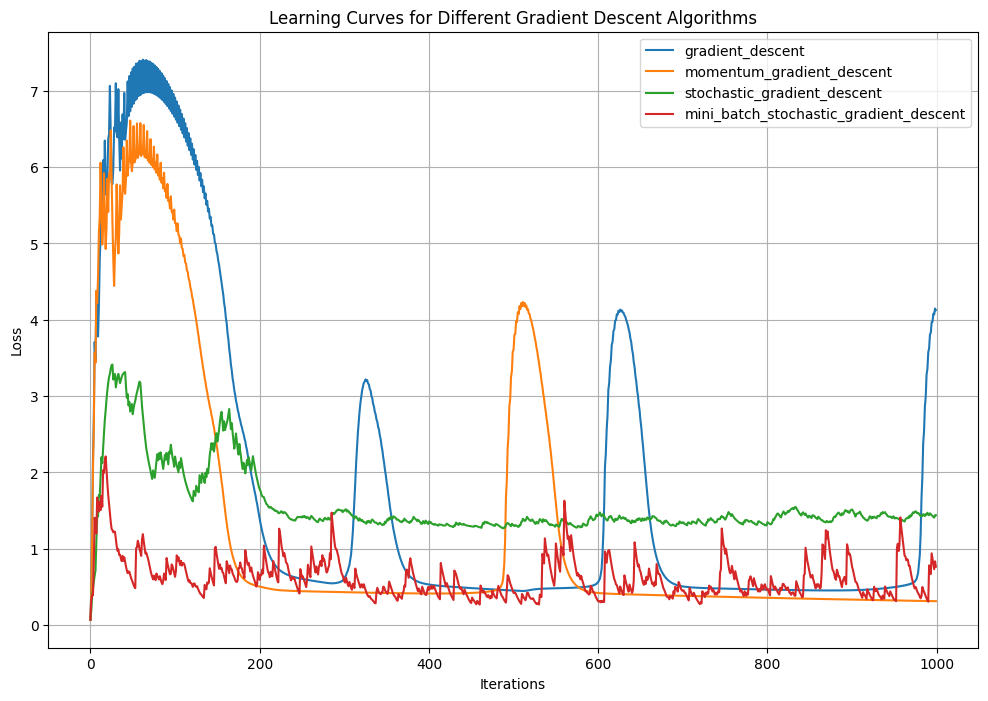

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets

# Assuming LogisticRegression class is already defined with all gradient descent methods

def train_and_get_loss(algorithm, X_train, y_train):
    regressor = LogisticRegression(learning_rate=0.0001, n_iters=1000, gd_algorithm=algorithm)
    regressor.fit(X_train, y_train)
    return regressor.losses

# Load dataset
dataset = datasets.load_breast_cancer()
X, y = dataset.data, dataset.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Algorithms to test
algorithms = [
    'gradient_descent',
    'momentum_gradient_descent',
    'stochastic_gradient_descent',
    'mini_batch_stochastic_gradient_descent'
]

def smooth_loss(loss_values, alpha=0.9):
    smoothed_losses = []
    ema = 0  # initial value of the exponential moving average

    for i, loss in enumerate(loss_values):
        ema = alpha * ema + (1 - alpha) * loss  # compute EWMA
        smoothed_losses.append(ema)

    return smoothed_losses

# Store losses for each algorithm
losses_dict = {}

for algo in algorithms:
    losses_dict[algo] = smooth_loss(train_and_get_loss(algo, X_train, y_train))

# Plot learning curves
plt.figure(figsize=(12, 8))
for algo, losses in losses_dict.items():
    plt.plot(losses, label=algo)

plt.title('Learning Curves for Different Gradient Descent Algorithms')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()